Install DGL

Import the necessary pacakges

In [54]:
import dgl
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt


**Q2**

import the karate dataset

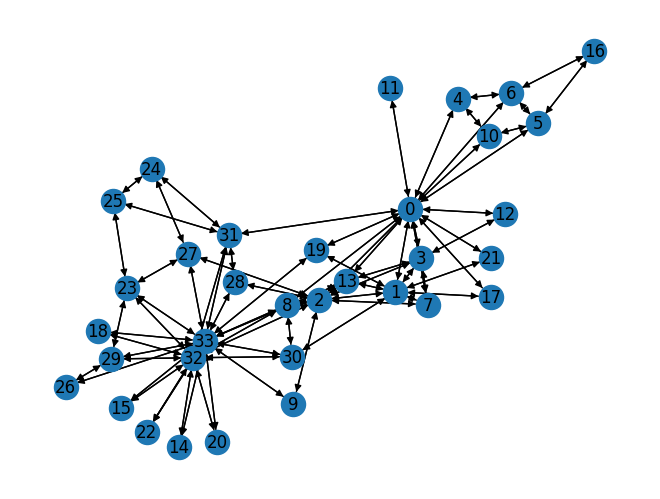

In [55]:
import dgl.data

dataset = dgl.data.KarateClubDataset()
g = dataset[0]
# type(g)
# nx.draw(g, with_labels=True)
nxg = dgl.to_networkx(g)
nx.draw(nxg, with_labels=True)

Preprocess the dataset

In [56]:
# Split edge set for training and testing
u, v = g.edges()

# Find all negative edges 
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the postive and negative graphes
pos_g = dgl.graph(
    (u, v), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [57]:
neg_g

Graph(num_nodes=34, num_edges=966,
      ndata_schemes={}
      edata_schemes={})

In [58]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2576, -0.2684],
        [ 0.1255, -0.0259],
        [-0.2963, -0.0916],
        [ 0.2193, -0.3923],
        [-0.4000,  0.1522],
        [ 0.1590, -0.3367],
        [-0.3907,  0.1462],
        [ 0.3673, -0.3640],
        [ 0.0974, -0.3411],
        [-0.1680,  0.0597],
        [-0.0819,  0.2620],
        [-0.1862,  0.2176],
        [ 0.0532,  0.1955],
        [ 0.0996, -0.0343],
        [ 0.3727, -0.0797],
        [-0.3579, -0.0134],
        [-0.0708,  0.0852],
        [-0.2174,  0.0498],
        [ 0.3280,  0.0310],
        [ 0.1778, -0.1355],
        [-0.3907, -0.3627],
        [ 0.0738,  0.1036],
        [ 0.0090,  0.3861],
        [-0.1729,  0.3721],
        [ 0.0723,  0.2688],
        [ 0.1062, -0.3643],
        [-0.1350, -0.0880],
        [ 0.0475, -0.3417],
        [-0.1591,  0.3574],
        [-0.3800,  0.1950],
        [-0.1183, -0.0329],
        [ 0.3927,  0.3047],
        [-0.0598,  0.1567],
        [ 0.2257, -0.0785]], requires_grad=True)

Build the model based on  GraphSAGE.





In [59]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the adjacency-based similarity loss

In [60]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [61]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))

      print()



In epoch 0, loss: 19.777231216430664

In epoch 1, loss: 14.455732345581055

In epoch 2, loss: 10.497328758239746

In epoch 3, loss: 7.591385364532471

In epoch 4, loss: 5.538262844085693

In epoch 5, loss: 4.049838066101074

In epoch 6, loss: 3.0333597660064697

In epoch 7, loss: 2.282757520675659

In epoch 8, loss: 1.7404851913452148

In epoch 9, loss: 1.344688057899475

In epoch 10, loss: 1.058735728263855

In epoch 11, loss: 0.8482593297958374

In epoch 12, loss: 0.6895633339881897

In epoch 13, loss: 0.5680397152900696

In epoch 14, loss: 0.476796954870224

In epoch 15, loss: 0.4070305824279785

In epoch 16, loss: 0.35386285185813904

In epoch 17, loss: 0.3121793866157532

In epoch 18, loss: 0.27882054448127747

In epoch 19, loss: 0.2524506747722626

In epoch 20, loss: 0.2310991734266281

In epoch 21, loss: 0.21384921669960022

In epoch 22, loss: 0.2005382925271988

In epoch 23, loss: 0.18989184498786926

In epoch 24, loss: 0.1810396909713745

In epoch 25, loss: 0.1736428439617157


Draw the embedding

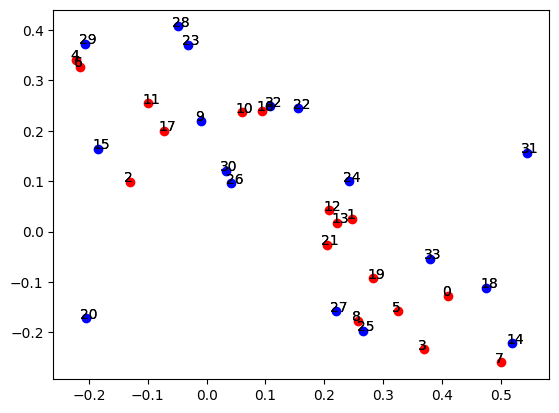

In [62]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


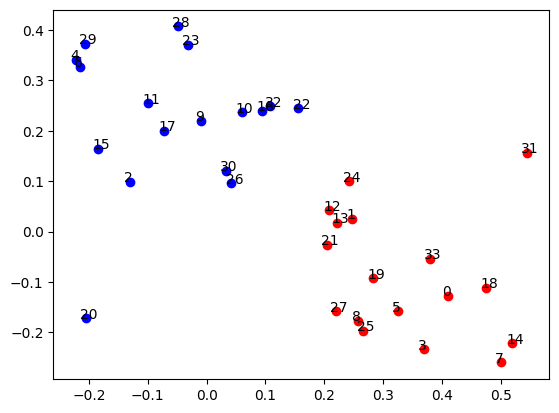

In [63]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

# Repeat the 3 steps above, but with 3 GNN layers and 2-hop similarity function.

You can modify the codes above.


Regenerate the training data that can be combined with the 2-hop similarity function. 

In [64]:
#obtain the two hop neighbor subgraph
sg,_ = dgl.khop_in_subgraph(g, 0, k=2)


node_id_map = {}
for i,org_id in enumerate(sg.ndata[dgl.NID]):
    node_id_map[i] = int(org_id.numpy())
    

###obtain the edges in original graph, as well as the edges in two hop neighbor subgraph.
u, v = g.edges()
u_s, v_s = sg.edges()

# Map the nodes with its original ID.
for j,uu in enumerate(u_s):
    u_s[j] = torch.tensor(node_id_map[int(uu.numpy())])

for j,vv in enumerate(v_s):
    v_s[j] = torch.tensor(node_id_map[int(vv.numpy())])


# Find all negative edges 
#(positive edge means the two nodes are connected in the two hop neighbors subgraph) 
adj = sp.coo_matrix((np.ones(len(u_s)), (u_s.numpy(), v_s.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

### build the positive and negative graph
pos_g = dgl.graph(
    (u_s, v_s), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [65]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2463,  0.0276],
        [-0.0526, -0.0216],
        [ 0.2115,  0.0094],
        [-0.2205,  0.2757],
        [ 0.3802, -0.0484],
        [ 0.1381, -0.1074],
        [ 0.2910, -0.2423],
        [-0.1597,  0.0932],
        [ 0.1480, -0.1631],
        [-0.0800,  0.0013],
        [-0.3974,  0.0325],
        [-0.2090,  0.2769],
        [-0.0082, -0.1950],
        [ 0.0679, -0.1482],
        [ 0.0896, -0.0633],
        [-0.2819, -0.3369],
        [ 0.1825, -0.1326],
        [ 0.1063,  0.0956],
        [-0.0690, -0.0123],
        [-0.2741,  0.3814],
        [ 0.1516,  0.2686],
        [ 0.2549, -0.1378],
        [ 0.3499,  0.3910],
        [ 0.2433, -0.0757],
        [-0.0358, -0.2855],
        [ 0.1101,  0.1055],
        [-0.1339,  0.2383],
        [-0.0694,  0.3791],
        [ 0.2296,  0.3068],
        [ 0.3634, -0.1733],
        [-0.1698,  0.3900],
        [ 0.2329, -0.2307],
        [ 0.3141, -0.4080],
        [ 0.3457, -0.0881]], requires_grad=True)

Build the model based on GraphSAGE.

In [66]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        
        self.gnn3 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        hidden2_ar = F.relu(hidden2)
        h = self.gnn3(g, hidden2_ar)
        return h

Define the two-hop similarity loss.

In [67]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [68]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))



/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 0.4792376160621643
In epoch 1, loss: 0.3558872640132904
In epoch 2, loss: 0.2786455750465393
In epoch 3, loss: 0.23613697290420532
In epoch 4, loss: 0.2044864296913147
In epoch 5, loss: 0.17890091240406036
In epoch 6, loss: 0.15980742871761322
In epoch 7, loss: 0.14570190012454987
In epoch 8, loss: 0.13605108857154846
In epoch 9, loss: 0.13003401458263397
In epoch 10, loss: 0.1255754679441452
In epoch 11, loss: 0.12163509428501129
In epoch 12, loss: 0.1181594505906105
In epoch 13, loss: 0.11510495096445084
In epoch 14, loss: 0.11243005841970444
In epoch 15, loss: 0.11008966714143753
In epoch 16, loss: 0.10804159939289093
In epoch 17, loss: 0.10624626278877258
In epoch 18, loss: 0.10466785728931427
In epoch 19, loss: 0.10327519476413727
In epoch 20, loss: 0.10204222798347473
In epoch 21, loss: 0.10094787180423737
In epoch 22, loss: 0.0999753326177597
In epoch 23, loss: 0.09911108762025833
In epoch 24, loss: 0.09834408015012741
In epoch 25, loss: 0.0976647287607193
In e


Draw the embedding

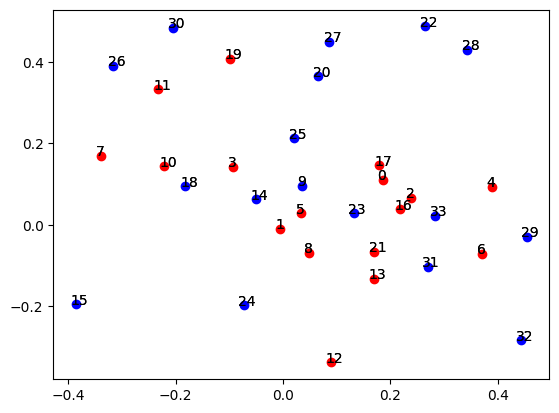

In [69]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


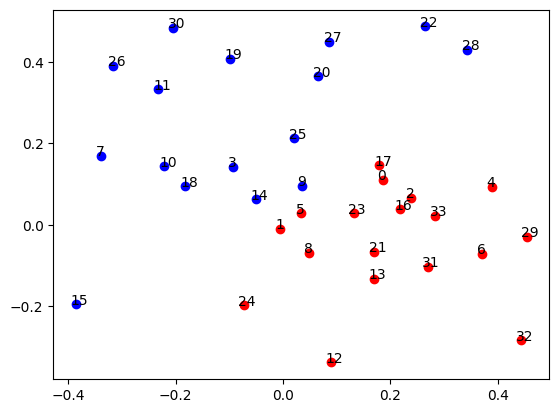

In [70]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

**Q3**
Node Classfication


import the Cora dataset

In [71]:
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
g_number_of_nodes = g.number_of_nodes()
g_numb_feats = g.ndata['feat'].shape[1]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Build the model based on  GraphSAGE.


In [72]:
'''please build the model'''
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build GraphSAGE layer '''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        h = F.relu(hidden2)
        return h

Define the linear classifier

In [73]:
'''please build the classifier'''
class Classifier(nn.Module):
    def __init__(self, h_feat, num_classes):
        super(Classifier, self).__init__()
        '''please build the linear classfier '''
        self.fc1 = nn.Linear( 
            in_features = h_feat,
            out_features = num_classes)

    def forward(self, in_feat):
        h = self.fc1(in_feat)
        return h

In [74]:
input = g.ndata['feat']
print(input)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Train the NN.

In [75]:

    h_feats = 16
    num_classes = 7
    input_feats = g.ndata['feat'].shape[1]
    g_number_of_nodes = g.number_of_nodes()
    input = g.ndata['feat']

    import itertools
    '''please complete the functions for the  model'''
    classifier = Classifier(h_feats, num_classes)
    model = Model(input_feats, h_feats)
    optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), classifier.parameters()), lr=0.01)

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]

    best_val_acc = 0.0
    best_test_acc = 0.0

    for e in range(100):
        '''please fill in the missing "Forward" and "Compute loss" in training process'''
        # Forward
        hidden = model(g, input)
        logits = classifier(hidden)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc





        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}".format(
                    e, loss, val_acc, test_acc
                )
            )

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 1.952, val acc: 0.058, test acc: 0.064
In epoch 1, loss: 1.939, val acc: 0.058, test acc: 0.064
In epoch 2, loss: 1.922, val acc: 0.058, test acc: 0.064
In epoch 3, loss: 1.904, val acc: 0.058, test acc: 0.064
In epoch 4, loss: 1.883, val acc: 0.066, test acc: 0.073
In epoch 5, loss: 1.859, val acc: 0.144, test acc: 0.151
In epoch 6, loss: 1.831, val acc: 0.210, test acc: 0.223
In epoch 7, loss: 1.798, val acc: 0.258, test acc: 0.258
In epoch 8, loss: 1.759, val acc: 0.264, test acc: 0.273
In epoch 9, loss: 1.714, val acc: 0.280, test acc: 0.280
In epoch 10, loss: 1.662, val acc: 0.302, test acc: 0.307
In epoch 11, loss: 1.603, val acc: 0.326, test acc: 0.336
In epoch 12, loss: 1.536, val acc: 0.370, test acc: 0.366
In epoch 13, loss: 1.464, val acc: 0.402, test acc: 0.390
In epoch 14, loss: 1.387, val acc: 0.418, test acc: 0.398
In epoch 15, loss: 1.306, val acc: 0.432, test acc: 0.416
In epoch 16, loss: 1.221, val acc: 0.446, test acc: 0.423
In epoch 17, loss: 1.133